In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import skimage as sk

In [25]:
patientNumber = "10"
regMethodDir = "gradientline"

dirpath = f"{os.getcwd()}\\input_files\\pacient_{patientNumber}\\registration\\{regMethodDir}\\pacient{patientNumber}"
imagesFile = np.load(f"{dirpath}Images.npz")
pointsInfoFile = np.load(os.path.join(f"{dirpath}Points.npz"))
saveState = False

In [26]:
images = {key: imagesFile[key] for key in imagesFile.files}
points = {key: pointsInfoFile[key] for key in pointsInfoFile.files}

movingImageRescaled = sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(images["movingImage"]), 
                                            0, 255), pixelID=sitk.sitkUInt8)
movingInitialImageRescaled = sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(images["movingInitialImage"]), 
                                            0, 255), pixelID=sitk.sitkUInt8)
movingFinalImageRescaled = sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(images["movingFinalImage"]), 
                                            0, 255), pixelID=sitk.sitkUInt8)
fixedImageRescaled = sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(images["fixedImage"]), 
                                            0, 255), pixelID=sitk.sitkUInt8)

In [31]:
type(movingImageRescaled) == sitk.Image

True

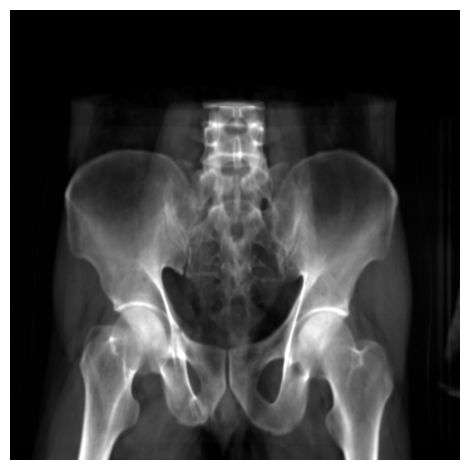

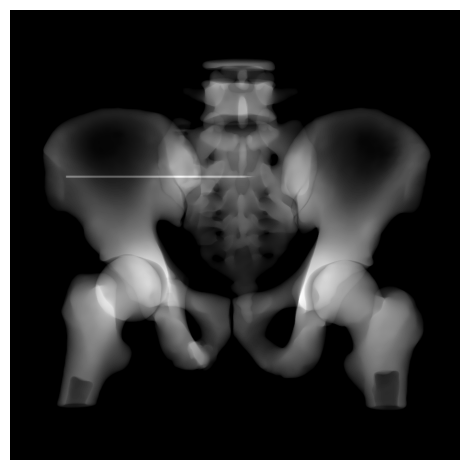

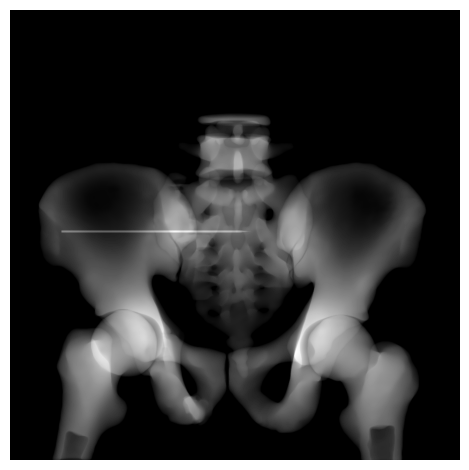

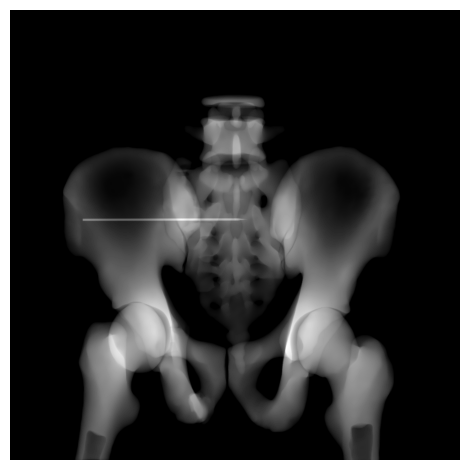

In [148]:
def plotImage(image, image_type, save):
    fig_image, ax_image = plt.subplots(1, 1)
    ax_image.imshow(sitk.GetArrayViewFromImage(image), cmap="gray")
    ax_image.set_axis_off()
    fig_image.tight_layout()
    
    # fig_moving, ax_moving = plt.subplots(1, 1)
    # ax_moving.imshow(sitk.GetArrayViewFromImage(moving_image), cmap="gray")
    # ax_moving.set_axis_off()
    # fig_moving.tight_layout()
    
    # fig_initial, ax_initial = plt.subplots(1, 1)
    # ax_initial.imshow(sitk.GetArrayViewFromImage(moving_initial), cmap="gray")
    # ax_initial.set_axis_off()
    # fig_initial.tight_layout()
    plt.show()
        
    if save:
        # fig_fixed.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}{regMethodDir}Fixed.svg", 
        #                   bbox_inches="tight")
        fig_image.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}{image_type}"
                          f".png", bbox_inches="tight", pad_inches=0)
        fig_image.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}{image_type}"
                          f".pdf", bbox_inches="tight", pad_inches=0)

plotImage(fixedImageRescaled, "Fixed", save=True)
plotImage(movingImageRescaled, "Moving", save=True)
plotImage(movingInitialImageRescaled, "Initial", save=True)
plotImage(movingFinalImageRescaled, "Final", save=True)

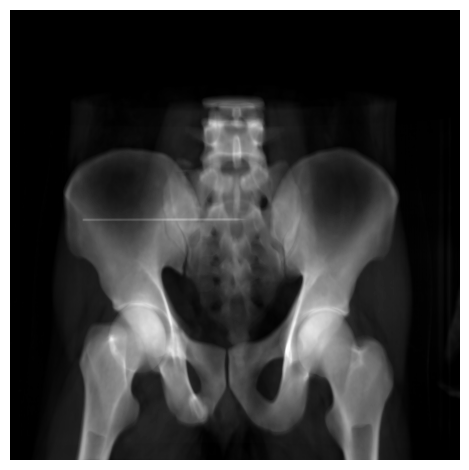

In [149]:
def plotAlphaBlend(image1: sitk.Image, image2, alpha=0.5, save=False):
    fig_alpha, ax_alpha = plt.subplots(1, 1)
    img1 = sitk.Cast(image1, sitk.sitkFloat32)
    img2 = sitk.Cast(image2, sitk.sitkFloat32)
    imageOutput = (alpha * img1) + (1 - alpha) * img2

    ax_alpha.imshow(sitk.GetArrayViewFromImage(imageOutput), cmap="gray")
    ax_alpha.set_axis_off()
    fig_alpha.tight_layout()
    plt.show()
    
    if save:
        fig_alpha.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}Alpha.pdf", 
                          bbox_inches="tight", pad_inches=0)
        fig_alpha.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}Alpha.png", 
                          bbox_inches="tight", pad_inches=0)

plotAlphaBlend(movingFinalImageRescaled, fixedImageRescaled, alpha=0.5, save=True)

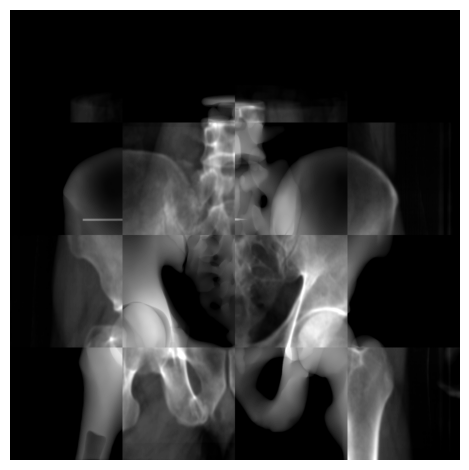

In [150]:
def plotCheckerboard(image1, image2, pattern=(4, 4), save=False):
    imagesCheckerboard = sitk.CheckerBoard(image1, image2, pattern)
    
    fig_check, ax_check = plt.subplots(1, 1)
    ax_check.imshow(sitk.GetArrayViewFromImage(imagesCheckerboard), cmap="gray")
    ax_check.set_axis_off()
    fig_check.tight_layout()
    plt.show()
    
    if save:
        fig_check.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}Checker"
                          f".png", bbox_inches="tight", pad_inches=0)
        fig_check.savefig(f"graficke_vystupy\\pacient_{patientNumber}\\pacient{patientNumber}Checker"
                          f".pdf", bbox_inches="tight", pad_inches=0)

plotCheckerboard(fixedImageRescaled, movingFinalImageRescaled, pattern=(4, 4), save=True)

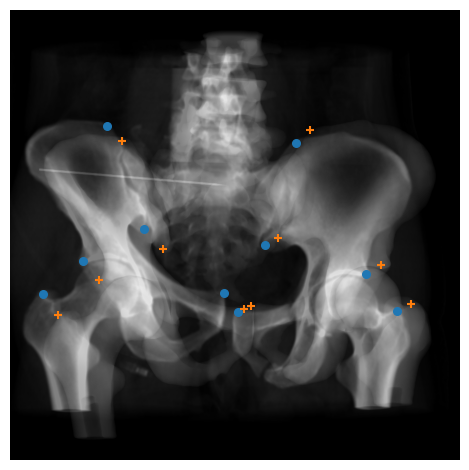

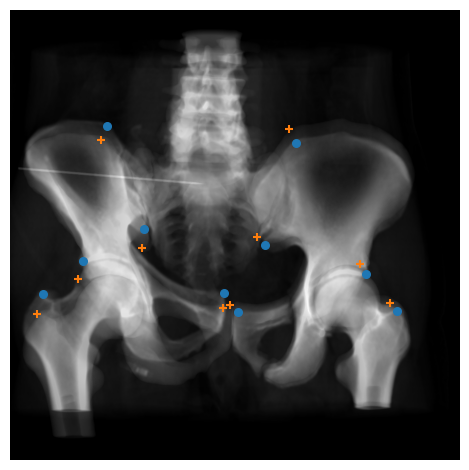

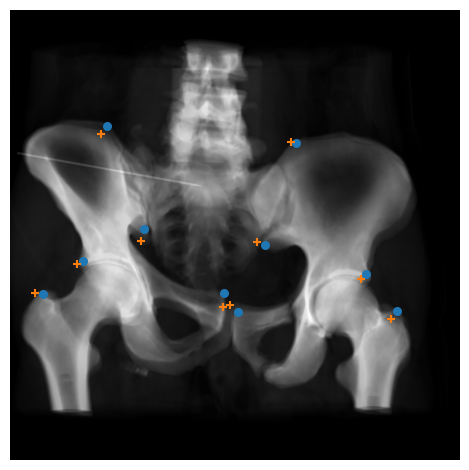

In [16]:
def plotImagesAndPoints(fixed_image, moving_image, 
                        fixed_points, moving_points, 
                        reg_stage, save=False):
    fig_points, ax_points = plt.subplots(1, 1)
    ax_points.imshow(sitk.GetArrayViewFromImage(fixed_image), cmap="gray")
    ax_points.imshow(sitk.GetArrayViewFromImage(moving_image), cmap="gray", alpha=0.5)
    ax_points.scatter(list(fixed_points.T)[0], list(fixed_points.T)[1], 
                c="#1f77b4", s=30, label="Fixní body")
    ax_points.scatter(list(moving_points.T)[0], list(moving_points.T)[1], 
                c="#ff7f0e", s=30, label="Pohyblivé body", marker="+")
    ax_points.set_axis_off()
    #ax_points.legend()
    fig_points.tight_layout()
    
    # fig_initial, ax_initial = plt.subplots(1, 1)
    # ax_initial.imshow(sitk.GetArrayViewFromImage(fixed_image), cmap="gray")
    # ax_initial.imshow(sitk.GetArrayViewFromImage(moving_initial), cmap="gray", alpha=0.5) # alpha = 0.5
    # ax_initial.scatter(list(points["fixedPoints"].T)[0], list(points["fixedPoints"].T)[1], 
    #             c="#1f77b4", s=30, label="Fixní body")
    # ax_initial.scatter(list(points["movingInitialPoints"].T)[0], list(points["movingInitialPoints"].T)[1], 
    #             c="#ff7f0e", s=30, label="Pohyblivé body")
    # ax_initial.set_axis_off()
    # fig_initial.tight_layout()
    # 
    # fig_final, ax_final = plt.subplots(1, 1)
    # ax_final.imshow(sitk.GetArrayViewFromImage(fixed_image), cmap="gray")
    # ax_final.imshow(sitk.GetArrayViewFromImage(moving_final), cmap="gray", alpha=0.5)
    # ax_final.scatter(list(points["fixedPoints"].T)[0], list(points["fixedPoints"].T)[1], 
    #             c="#1f77b4", s=30, label="Fixní body")
    # ax_final.scatter(list(points["movingFinalPoints"].T)[0], list(points["movingFinalPoints"].T)[1], 
    #             c="#ff7f0e", s=30, label="Pohyblivé body")
    # ax_final.set_axis_off()
    # # ax_final.legend(fontsize=12)
    # fig_final.tight_layout()
    # plt.show()
        
    if save: # pacient{patientNumber}{reg_stage}Points
        fig_points.savefig(f"D:\\skola\\DP\\dp_text\\Figures\\png\\p{patientNumber}{reg_stage}.png", 
                           bbox_inches="tight", pad_inches=0)
        fig_points.savefig(f"D:\\skola\\DP\\dp_text\\Figures\\pdf\\p{patientNumber}{reg_stage}.pdf", 
                           bbox_inches="tight", pad_inches=0)

plotImagesAndPoints(fixedImageRescaled, movingImageRescaled, 
                    fixed_points=points["fixedPoints"], moving_points=points["movingPoints"], 
                    reg_stage="PrePoints", save=True)
plotImagesAndPoints(fixedImageRescaled, movingInitialImageRescaled,
                     fixed_points=points["fixedPoints"], moving_points=points["movingInitialPoints"],
                     reg_stage="InitialPoints", save=True)
plotImagesAndPoints(fixedImageRescaled, movingFinalImageRescaled, 
                     fixed_points=points["fixedPoints"], moving_points=points["movingFinalPoints"],
                     reg_stage="FinalPoints", save=True)

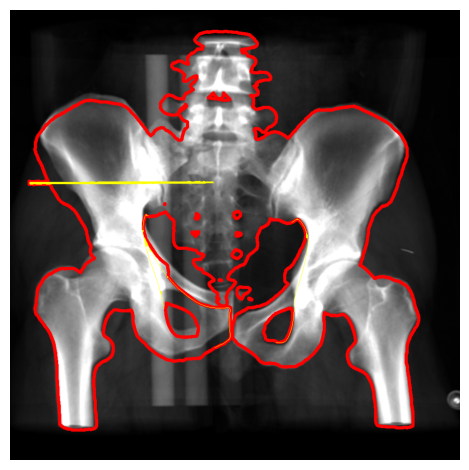

In [146]:
def plotImageAndEdge(fixed_image, moving_image,
                     low_thresh_guide: float = 0.0, high_thresh_guide: float = 0.0,
                     save=False):
    
    
    #input_image = sitk.GetImageFromArray(moving_image)
    moving_image = sitk.GetImageFromArray(moving_image)
    guide_edges = sitk.CannyEdgeDetection(moving_image, 
                                          lowerThreshold=low_thresh_guide, 
                                          upperThreshold=high_thresh_guide)
    # moving_mask = sitk.GetImageFromArray(moving_image)
    moving_image[moving_image > 0.0] = 1.0
    bone_edges = sitk.CannyEdgeDetection(moving_image)    
    
    guide_closed = (sk.morphology.closing(sitk.GetArrayFromImage(guide_edges), 
                                          footprint=np.ones(shape=(5, 5))).astype(np.uint8))
    bones_dilated = 2 * sk.morphology.dilation(sitk.GetArrayFromImage(bone_edges), 
                                           footprint=np.ones(shape=(4, 4))).astype(np.uint8)
    
    label_map = sitk.GetImageFromArray(guide_closed + bones_dilated)
    bones_dilated_sitk = sitk.GetImageFromArray(bones_dilated)
    
    yellow = [255, 255, 0]
    red = [255, 0, 0]
    labeled_image = sitk.LabelOverlay(fixed_image, label_map,
                                      colormap=red+yellow,
                                    opacity=1.0, backgroundValue=0)

    # fixed_image_labels = sk.color.label2rgb(guide_closed + bones_dilated, 
    #                                         colors=colors,
    #                                         bg_label=0).astype(np.uint8)
    # rescale = sk.exposure.rescale_intensity(fixed_image_labels, 
    #                                         out_range=(0, 255))

    fig_edge, ax_edge = plt.subplots(1, 1)
    ax_edge.imshow(sitk.GetArrayFromImage(labeled_image))
    ax_edge.set_axis_off()
    fig_edge.tight_layout()
    plt.show()
    if save:
        fig_edge.savefig(f"pacient{patientNumber}Edges.png",  # graficke_vystupy\\pacient_{patientNumber}\\
                         bbox_inches="tight", pad_inches=0)
    return labeled_image

label_image = plotImageAndEdge(fixedImageRescaled, images["movingFinalImage"],
                 low_thresh_guide=0.1, high_thresh_guide=0.6, save=False)


In [125]:
label_image.GetPixelIDTypeAsString()

'vector of 8-bit unsigned integer'

In [132]:
label_image.GetSize()

(1000, 1000)

In [134]:
rgb_image[0] = sitk.VectorIndexSelectionCast(label_image, 0, sitk.sitkUInt8)
rgb_image[1] = sitk.VectorIndexSelectionCast(label_image, 1, sitk.sitkUInt8)
rgb_image[2] = sitk.VectorIndexSelectionCast(label_image, 2, sitk.sitkUInt8)

IndexError: cannot paste source with size [1, 1000, 3] into destination with size (1000, 1000)

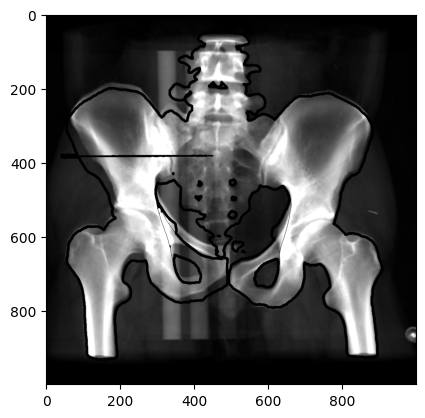

In [137]:
plt.imshow(sitk.GetArrayFromImage(sitk.VectorIndexSelectionCast(label_image, 2, sitk.sitkUInt8)), cmap="gray")

In [138]:
array = sitk.GetArrayFromImage(label_image)
arr = sitk.GetImageFromArray(array)

In [140]:
arr.GetPixelIDTypeAsString()

'8-bit unsigned integer'

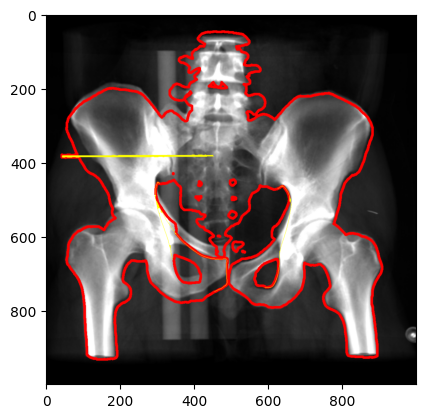

In [141]:
plt.imshow(sitk.GetArrayFromImage(arr))